In [1]:
import fiftyone as fo
import fiftyone.zoo as foz

In [2]:
# loading a simple dataset
dataset = fo.load_dataset("quickstart")

In [3]:
# loading a dataset with a few more parameters
dataset = foz.load_zoo_dataset(
              "open-images-v7",
              split="validation",
              label_types=["detections"],
              classes=["Fish"],
              max_samples=100,
          )

Necessary images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'open-images-v7-validation-100'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [6]:
# confusing error - can someone try on their own machine, was previously working for me. stackoverflow issue opened at: https://stackoverflow.com/questions/77750059/graphql-api-error-unhashable-type-strawberryannotation-fifty-one-app?noredirect=1#comment137076286_77750059
# otherwise this is an interface to visualize and interact with the dataset (not a necessity but a benefit nonetheless - interface interacts with python code too)

session = fo.launch_app(dataset)

In [14]:
# details about new dataset
dataset_stats = dataset.stats()
display(dataset_stats)
dataset_size = (dataset_stats['samples_count'])
views = dataset.take(dataset_size)

#get specifics from the data (images), such as id, filepath, ground_truths (i.e., labels) 
display(views.values)


{'samples_count': 100,
 'samples_bytes': 113949,
 'samples_size': '111.3KB',
 'total_bytes': 113949,
 'total_size': '111.3KB'}

<bound method SampleCollection.values of Dataset:     open-images-v7-validation-100
Media type:  image
Num samples: 100
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
View stages:
    1. Take(size=100, seed=None)>

In [16]:
from ultralytics import YOLO
from IPython.display import display, Image

# creates instance of specificed model, makes a prediction using that model on a photo in memory with a given confidence level
model = YOLO('yolov8n.pt')
results = model.predict(source='https://media.roboflow.com/notebooks/examples/dog.jpeg', conf = 0.25)


Found https://media.roboflow.com/notebooks/examples/dog.jpeg locally at dog.jpeg
image 1/1 c:\Users\aidan\Desktop\AUVIC\kraken\dog.jpeg: 640x384 1 person, 1 car, 1 dog, 106.3ms
Speed: 3.0ms preprocess, 106.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


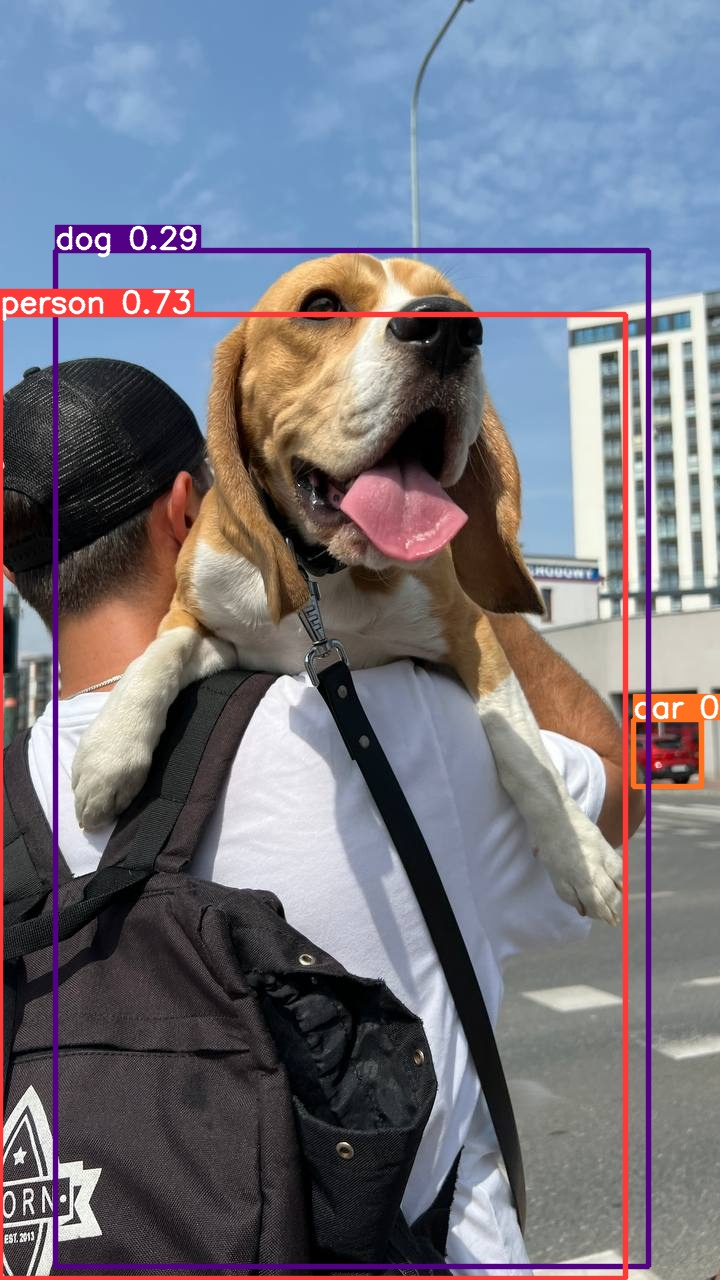

In [18]:
# prediction result output - example of model running
Image(filename='runs/detect/predict/dog.jpeg', height = 600)

In [21]:
# yolov8 was originally trained on the COCO dataset which is comprehensive but probably does not cover what we need it to cover so we must re-trian
# interacting with aidan's roboflow account where he has uploaded the previously downloaded data and started to annotate images in order to train YOLOv8 model

from roboflow import Roboflow
rf = Roboflow(api_key="39FU5HkgnKvA6VXwzz8J")
project = rf.workspace("object-detection-bounding-box-gpn4e").project("aquarium-detection-pjw4z")
dataset = project.version(1).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.0.231, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to Aquarium-Detection-1 in yolov8:: 100%|██████████| 98/98 [00:00<00:00, 1365.54it/s]


In [22]:
# code to train model, trying to see if there is a more pythonic way of writing this - takes a while even for the little bit of data being used

!yolo task = detect mode = train model=yolov8s.pt data={dataset.location}/data.yaml epochs=5 imgsz=640

New https://pypi.org/project/ultralytics/8.0.234 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.231 🚀 Python-3.11.4 torch-2.0.1+cu118 CPU (11th Gen Intel Core(TM) i7-11390H 3.40GHz)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=c:\Users\aidan\Desktop\AUVIC\kraken\Aquarium-Detection-1/data.yaml, epochs=5, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train8, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_mas


train: Scanning C:\Users\aidan\Desktop\AUVIC\kraken\Aquarium-Detection-1\Aquarium-Detection-1\train\labels.cache... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<?, ?it/s]
train: Scanning C:\Users\aidan\Desktop\AUVIC\kraken\Aquarium-Detection-1\Aquarium-Detection-1\train\labels.cache... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<?, ?it/s]

val: Scanning C:\Users\aidan\Desktop\AUVIC\kraken\Aquarium-Detection-1\Aquarium-Detection-1\valid\labels.cache... 9 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9/9 [00:00<?, ?it/s]
val: Scanning C:\Users\aidan\Desktop\AUVIC\kraken\Aquarium-Detection-1\Aquarium-Detection-1\valid\labels.cache... 9 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9/9 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]
        1/5         0G      1.689      6.529      2.052         58        640:   0%|          | 0/2 [00:41<?, ?it/s]
        1/5         0G      1.689      6.529      2.052         58        640:  

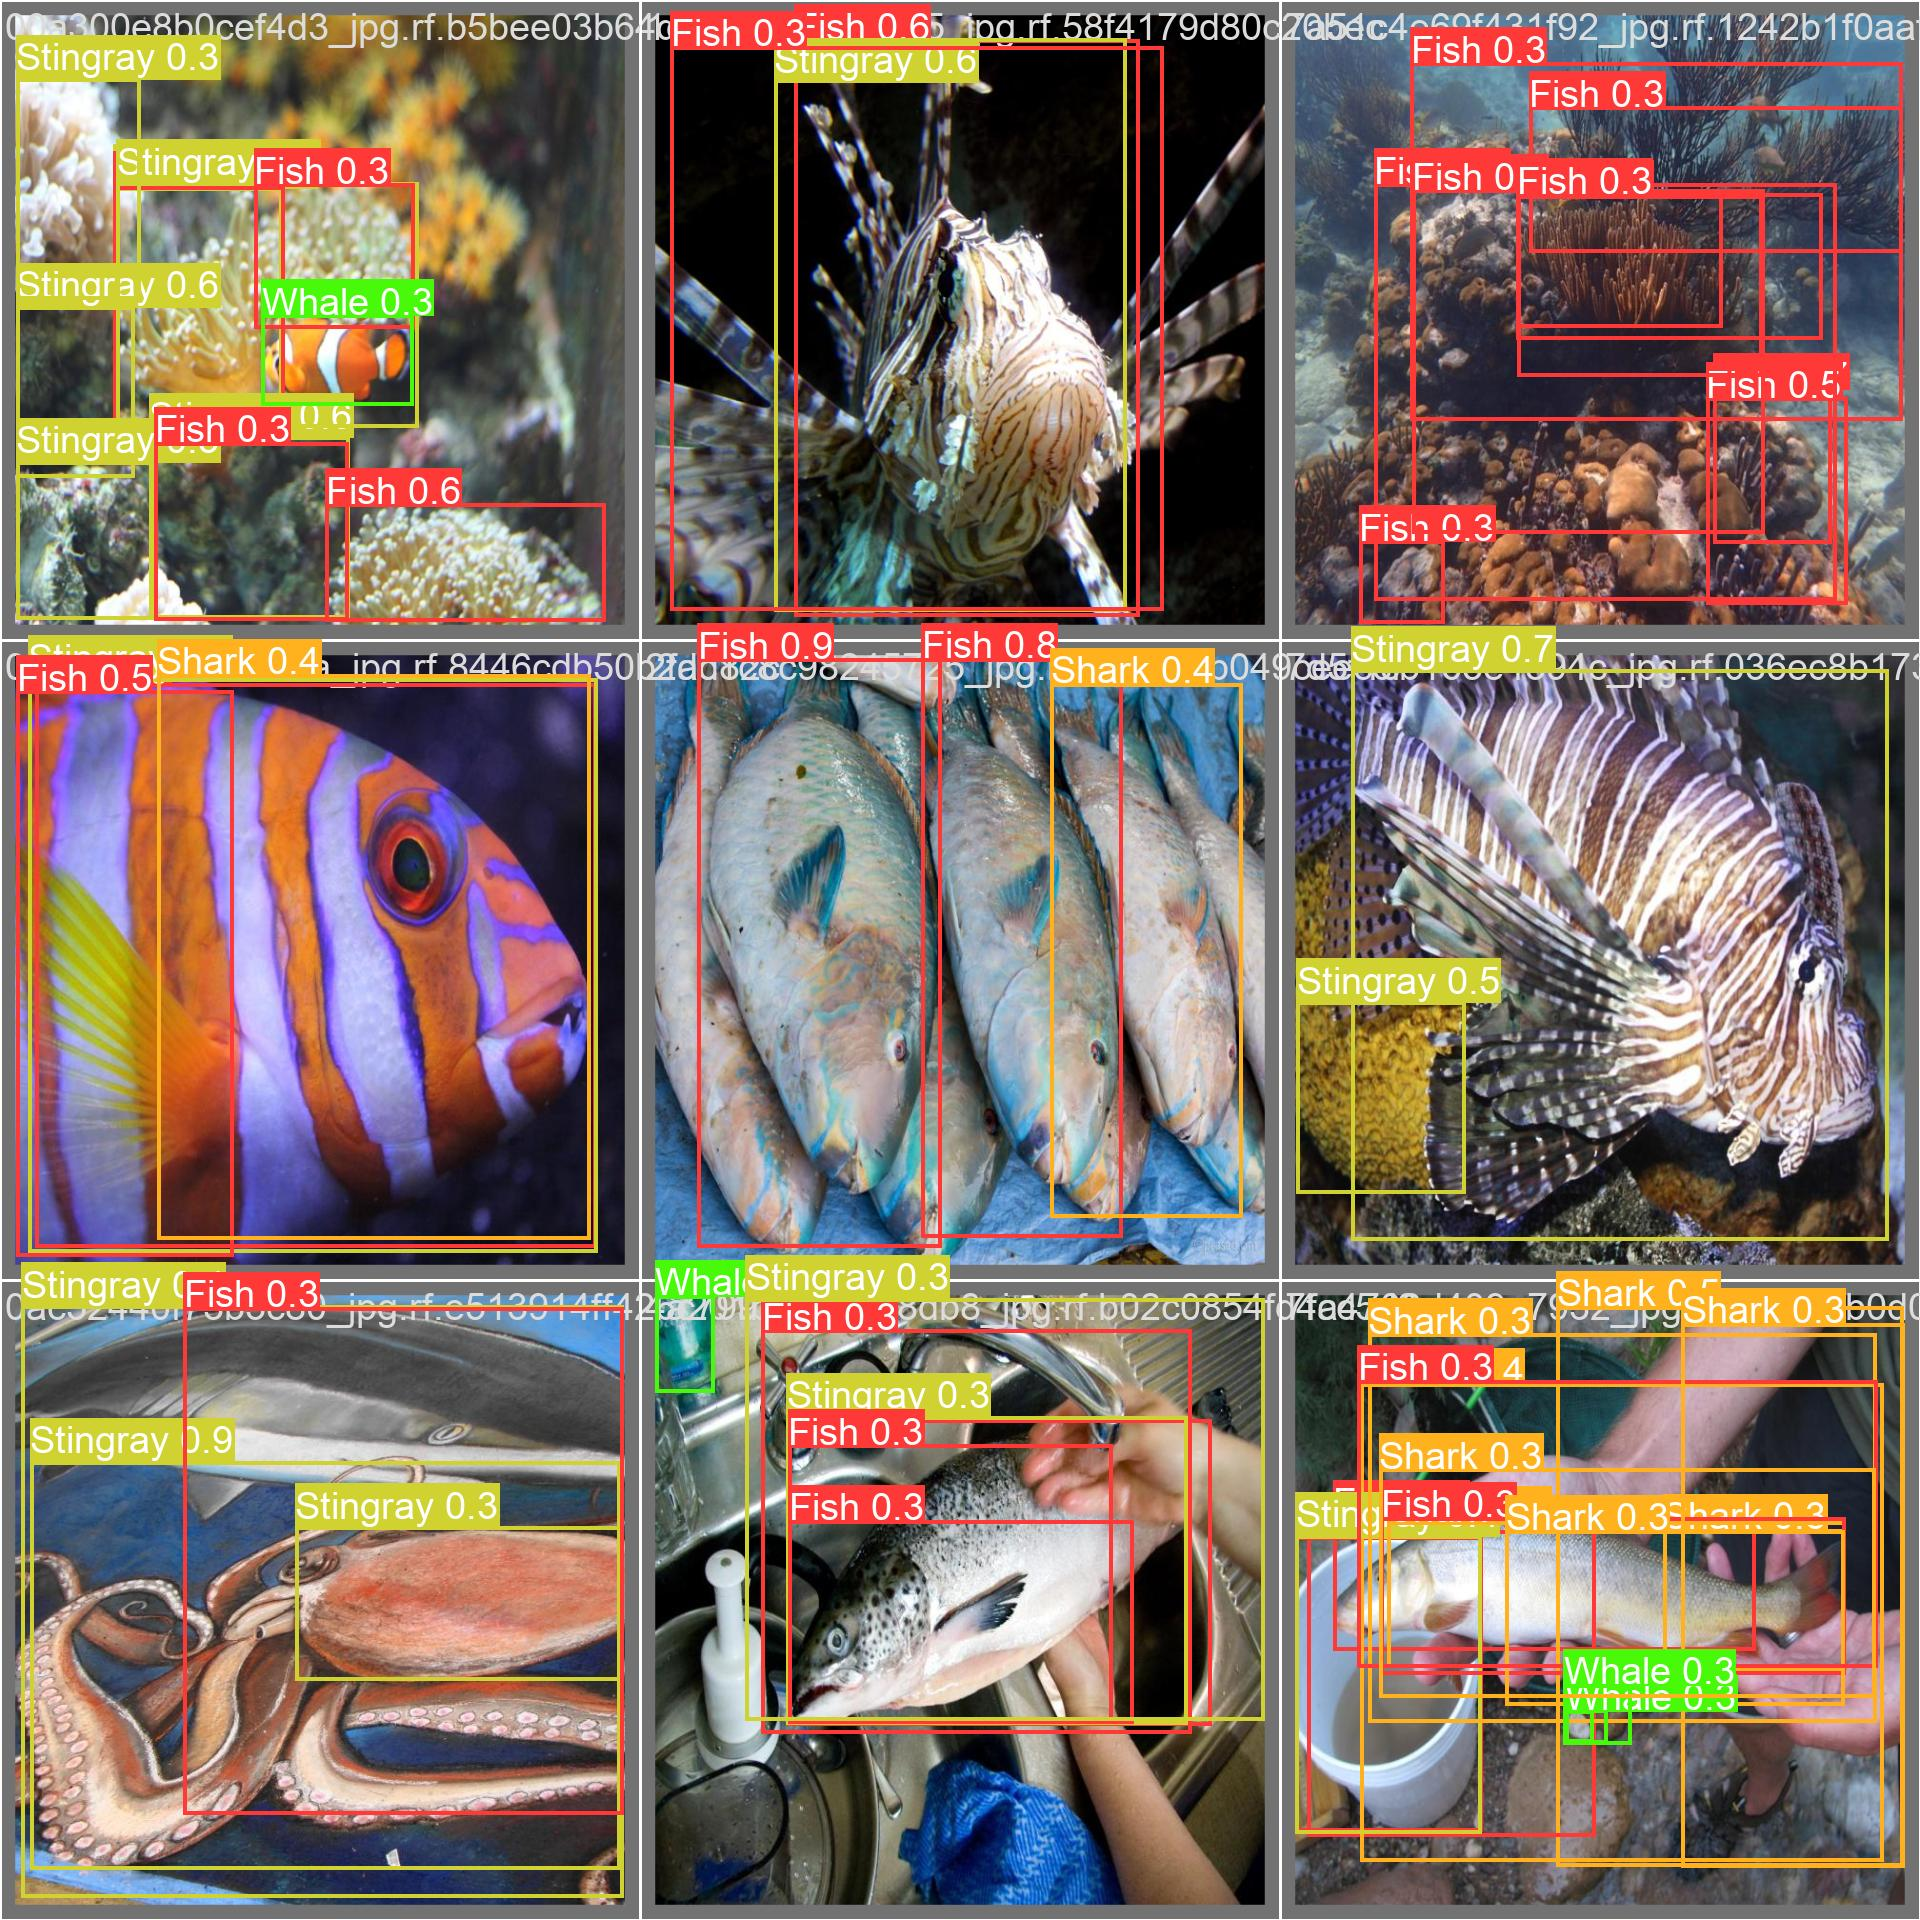

In [23]:
# output on validation set, rough proxy for test data results -> clearly suboptimal, but proof of concept
Image(filename='runs/detect/train6/val_batch0_pred.jpg')